In [1]:
# Libraries used for the analysis
import mdtraj as md 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import itertools as it     # utilities for combining iterators
from tqdm import tqdm,trange 

# NAC Distribution

In [8]:
data={"top" : "pdb.pdb"}
pd.set_option('display.max_rows', 1000)
qbins=np.arange(-1.5,1.5,0.01) # Charge bins
top=data["top"]
box=md.load(top).unitcell_vectors
tmp_list=[]
for s in tqdm(np.arange(50000,100000,1000), 
                  desc="System", leave=True):
    #Load coordinates and charges
    cor="/charges/{0}/{0}.xyz".format(s)
    chg="/charges/{0}/DDEC6_even_tempered_net_atomic_charges.xyz".format(s)
    fr=md.load_xyz(cor,top)
    fr.unitcell_vectors = np.repeat(box,1, axis=0) 
    # Calculate coordination numbers
    N={}
    Nh={}
    name={}
    for i in fr.top.select('all'):
        if fr.top.atom(i).element.symbol=='Zn':
            N[i]=len(md.compute_neighbors(fr, 0.25, [i], 
                                          fr.top.select("element 'O'"),periodic=True)[0])
            Nh[i]=0
            name[i]=fr.top.atom(i).element.symbol+str(N[i])+str(Nh[i])
        if fr.top.atom(i).element.symbol=='O': 
            N[i]=len(md.compute_neighbors(fr, 0.25, [i], 
                                           fr.top.select("element 'Zn'"),periodic=True)[0])
            
            Nh[i]=len(md.compute_neighbors(fr, 0.13, [i], 
                                           fr.top.select("element 'H'"),periodic=True)[0])
            name[i]=fr.top.atom(i).element.symbol+ str(N[i])+str(Nh[i])
        if fr.top.atom(i).element.symbol=='H':  
            N[i]=len(md.compute_neighbors(fr,0.13, [i], 
                                           fr.top.select("element 'O'"),periodic=True)[0])
            Nh[i]=0
            name[i]=fr.top.atom(i).element.symbol+ str(N[i])+str(Nh[i])            
    
    for i in fr.top.select('all'):
        if name[i]=='O12':
         
            Zn3=md.compute_neighbors(fr, 0.25, [i], 
                                           fr.top.select("element 'Zn'"),periodic=True)[0][0]
            name[i]='OWS'
            name[Zn3]='Zn30'
    result= pd.DataFrame.from_dict(name, orient = 'index')
    result.rename(columns={'index': 'Column1', 0: 'name'}, inplace=True)
    n=!head -n 1 {chg}
    q=pd.read_table(chg, delim_whitespace=True, header=None, comment="#",
                          skiprows=2, nrows=int(n.n), usecols=[4])
    result["charge"]=q
    result ["i"]= result.index
    result=result.assign(snapshot=s)
    tmp_list.append(result)        
charge=pd.concat(tmp_list, ignore_index=True)
del(charge["i"])

charge=charge.query("snapshot > 0")\
             .groupby("name".split())\
             .apply(lambda x: pd.Series(pd.cut(x.charge, qbins, labels=qbins[:-1], 
                                     include_lowest=True).astype(float).value_counts(),
                                     name="count"))\
             .reset_index()\
             .rename(columns={"level_1" : "q"}) 
charge=charge.groupby("name")\
              .apply(lambda x: x.assign(count=x["count"]/(x["count"].sum()))\
                                .reset_index(drop=True))                                         
charge=charge.reset_index(drop=True)
charge["property"]="NAC"
charge["surface"]="1"
charge.to_excel('charge.xlsx', engine='xlsxwriter',index=False) 

System:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-8-e60891f99c85>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N[i]=len(md.compute_neighbors(fr, 0.25, [i],
<ipython-input-8-e60891f99c85>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for

In [12]:
files=['charge-surface1-lastupdate.xlsx','cam-surface1-lastupdate.xlsx','charge-surface2-lastupdate.xlsx','cam-surface2-lastupdate.xlsx']
df = pd.DataFrame()
for file in files:
    if file.endswith('.xlsx'):
        df = df.append(pd.read_excel(file), ignore_index=True) 
df.head() 
df.to_excel('last-update_AIMD.xlsx')
df = df.append(pd.read_excel(file), ignore_index=True) 
df.head()

,name,q,count,property,surface
0,H10,0.37,0.285295,NAC,1
1,H10,0.38,0.235625,NAC,1
2,H10,0.36,0.197822,NAC,1
3,H10,0.39,0.119403,NAC,1
4,H10,0.35,0.087962,NAC,1


/home/masa1771/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


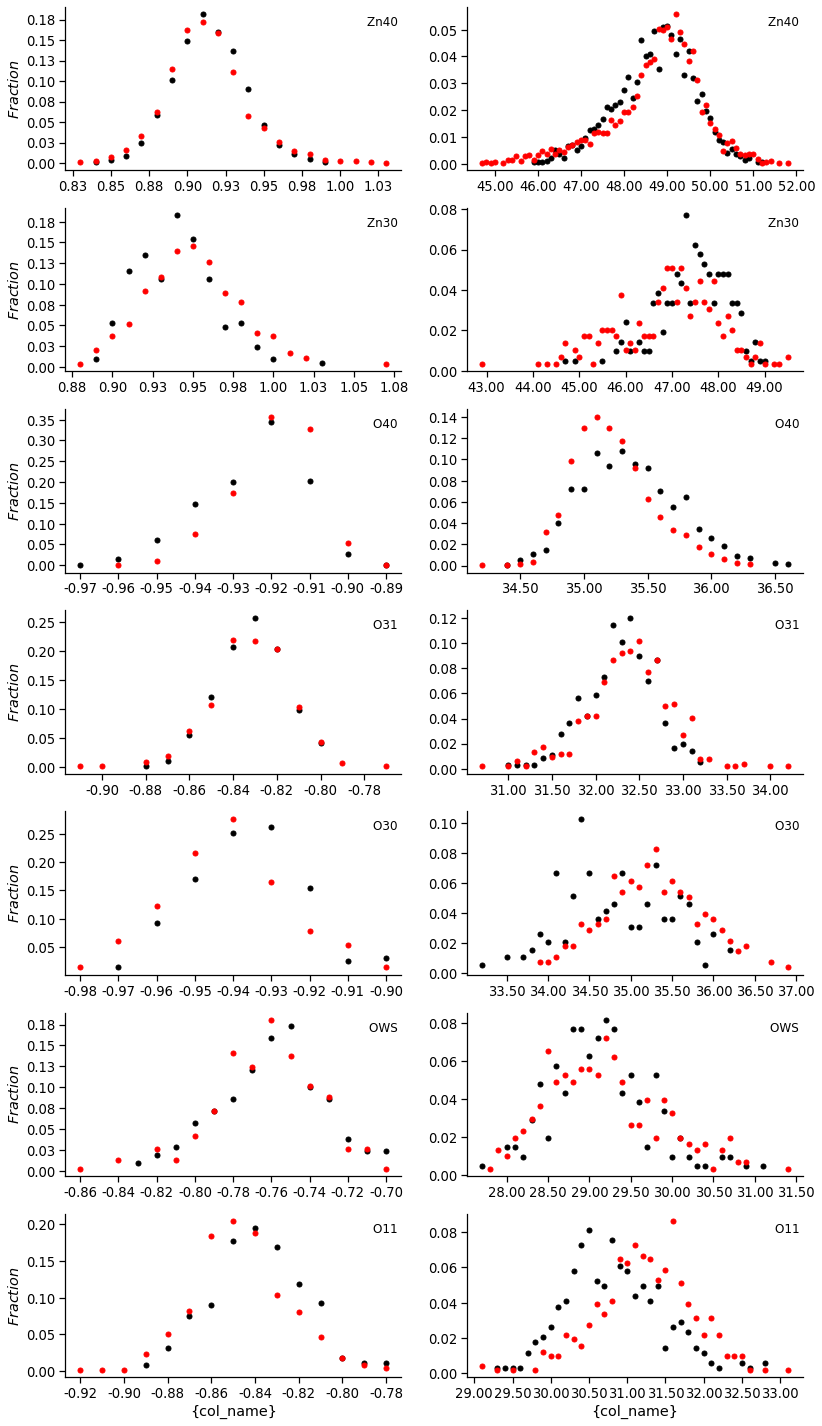

In [238]:
from matplotlib.ticker import FormatStrFormatter
flatui = ["black", "red"]
profiles = pd.read_excel("last-update_AIMD.xlsx").drop_duplicates().reset_index(drop=True)
with sns.plotting_context("notebook", font_scale=1.2):
        g=sns.FacetGrid(profiles, 
                col="property", hue="surface",row="name",
                row_order="Zn40 Zn30 O40 O31 O30 OWS O11".split(),
                margin_titles=False,  palette=sns.color_palette(flatui),#xlim=(0.15,0.66),ylim=(0,40),
                aspect=2.1, size=3.0,
                sharex=False, sharey=False)
g.map(plt.plot,"q", "count",marker=".",ls="", markersize=10) 

for ax in g.axes.flat:
    ax.set_title("")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    hs,ls = ax.get_legend_handles_labels()
g.set_titles(r"{row_name} ",
             loc="right", y=0.85, size=12)
g.set_axis_labels(r"{col_name}", r"$Fraction$")
#g.set_major_formatter(FormatStrFormatter('%.2f'))
g.fig.tight_layout(pad=5, h_pad=1, w_pad=2)
g.savefig("distribution-lastupdate.png", dpi=400)

# Population analysis

In [30]:
data={"cor" : "surface-1-pos-1-total.xyz","top" : "ZnO-sol.pdb"}
tmp_list=[]
cor=data["cor"]
top=data["top"]
traj=md.load(cor, top=top)
frame=0
box=md.load(top).unitcell_vectors

for s in tqdm(np.arange(60000,100000,100), 
                  desc="System", leave=True):
    frame +=1
    fr=traj[traj.time==s]
    fr.unitcell_vectors = np.repeat(box,1, axis=0) 
    N={}
    Nh={}
    name={}
  #  element={}
    for i in fr.top.select('all'):
   #     element[i]=str(fr.top.atom(i).element.symbol())
        if fr.top.atom(i).element.symbol=='Zn':
            N[i]=len(md.compute_neighbors(fr, 0.25, [i], 
                                          fr.top.select("element 'O'"),periodic=True)[0])
            Nh[i]=0
            name[i]=fr.top.atom(i).element.symbol+str(N[i])+str(Nh[i])
        if fr.top.atom(i).element.symbol=='O': 
            N[i]=len(md.compute_neighbors(fr, 0.25, [i], 
                                           fr.top.select("element 'Zn'"),periodic=True)[0])
            
            Nh[i]=len(md.compute_neighbors(fr, 0.13, [i], 
                                           fr.top.select("element 'H'"),periodic=True)[0])
            name[i]=fr.top.atom(i).element.symbol+ str(N[i])+str(Nh[i])
        if fr.top.atom(i).element.symbol=='H':  
            N[i]=len(md.compute_neighbors(fr,0.13, [i], 
                                           fr.top.select("element 'O'"),periodic=True)[0])
            Nh[i]=0
            name[i]=fr.top.atom(i).element.symbol+ str(N[i])+str(Nh[i])   
            
    result= pd.DataFrame.from_dict(name, orient = 'index')
    
    result.rename(columns={'index': 'Column1', 0: 'name'}, inplace=True)
    tmp_list.append(result) 
total=pd.concat(tmp_list, ignore_index=True)

System:   0%|          | 0/400 [00:00<?, ?it/s]<ipython-input-30-6419e09c1375>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N[i]=len(md.compute_neighbors(fr, 0.25, [i],
<ipython-input-30-6419e09c1375>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link 

In [32]:
print(frame)
pop=total.groupby('name', axis=0)\
           .apply(lambda x: x.value_counts()/frame)
print(pop)

400
name  name
H10   H10     177.7450
H20   H20       0.2550
O01   O01       0.0200
O02   O02      76.9625
O03   O03       0.0200
O11   O11       7.4025
O12   O12       4.5950
O21   O21       0.0025
O30   O30       4.3450
O31   O31       7.6550
O40   O40      35.9975
Zn30  Zn30      0.0075
Zn40  Zn40     47.9925
dtype: float64


In [34]:
pop=total.groupby('name', axis=0)\
           .apply(lambda x: x.value_counts()/frame)
print(pop)

name  name
H10   H10     179.7125
H20   H20       0.2875
O02   O02      73.6550
O03   O03       0.0025
O11   O11      10.1425
O12   O12       6.2000
O21   O21       0.0125
O30   O30       5.5750
O31   O31      10.4150
O40   O40      47.9975
Zn30  Zn30      0.0150
Zn40  Zn40     63.6425
Zn50  Zn50      0.3425
dtype: float64


# Oxygen atom time evolotion

In [169]:
data={"cor" : "surface-1-pos-1-total.xyz","top" : "ZnO-sol.pdb"}
tmp_list=[]
cor=data["cor"]
top=data["top"]
traj=md.load(cor, top=top)
frame=0
box=md.load(top).unitcell_vectors

for s in tqdm(np.arange(0,100000,50), 
                  desc="System", leave=True):
    frame +=1
    fr=traj[traj.time==s]
    fr.unitcell_vectors = np.repeat(box,1, axis=0) 
    N={}
    Nh={}
    name={}
  #  element={}
    for i in fr.top.select('all'):
   #     element[i]=str(fr.top.atom(i).element.symbol())
        if fr.top.atom(i).element.symbol=='Zn':
            N[i]=len(md.compute_neighbors(fr, 0.25, [i], 
                                          fr.top.select("element 'O'"),periodic=True)[0])
            Nh[i]=0
            name[i]=fr.top.atom(i).element.symbol+str(N[i])+str(Nh[i])
        if fr.top.atom(i).element.symbol=='O': 
            N[i]=len(md.compute_neighbors(fr, 0.25, [i], 
                                           fr.top.select("element 'Zn'"),periodic=True)[0])
            
            Nh[i]=len(md.compute_neighbors(fr, 0.13, [i], 
                                           fr.top.select("element 'H'"),periodic=True)[0])
            name[i]=fr.top.atom(i).element.symbol+ str(N[i])+str(Nh[i])
        if fr.top.atom(i).element.symbol=='H':  
            N[i]=len(md.compute_neighbors(fr,0.13, [i], 
                                           fr.top.select("element 'O'"),periodic=True)[0])
            Nh[i]=0
            name[i]=fr.top.atom(i).element.symbol+ str(N[i])+str(Nh[i])   
            
    result= pd.DataFrame.from_dict(name, orient = 'index').assign(time=frame)
    
    result.rename(columns={'index': 'Column1', 0: 'name'}, inplace=True)
    tmp_list.append(result) 
total=pd.concat(tmp_list, ignore_index=True)

KeyboardInterrupt: 

In [167]:
pop=total.groupby(['name','time'], axis=0)\
           .apply(lambda x: x.value_counts())
pop.name="frequency"
pop.to_excel('oxygen-population-surf1.xlsx',engine='xlsxwriter',index=True)
pop.to_csv('oxygen-population-surf1.csv',sep=' ',index=True)